## Problem 1

### Correlation and Independence of $Z$ and $Z^2$

### Step 1: Compute the Covariance $\text{Cov}(Z, Z^2)$

The covariance between two random variables $X$ and $Y$ is given by:

$$ \text{Cov}(X, Y) = E[XY] - E[X]E[Y] $$

Here, we set $X = Z$ and $Y = Z^2$, so:

$$ \text{Cov}(Z, Z^2) = E[Z \cdot Z^2] - E[Z]E[Z^2] $$

Since $Z \sim N(0,1)$, we know:

$$ E[Z] = 0, \quad E[Z^2] = \text{Var}(Z) = 1. $$

Now compute $E[Z^3]$:

$$ E[Z^3] = \int_{-\infty}^{\infty} z^3 \frac{1}{\sqrt{2\pi}} e^{-z^2/2} dz. $$

Since the standard normal distribution is symmetric about zero, all its odd moments, including $E[Z^3]$, are zero:

$$ E[Z^3] = 0. $$

Thus, the covariance simplifies to:

$$ \text{Cov}(Z, Z^2) = 0 - (0 \times 1) = 0. $$

### Step 2: Compute the Correlation $\rho(Z, Z^2)$

The correlation coefficient is given by:

$$ \rho(Z, Z^2) = \frac{\text{Cov}(Z, Z^2)}{\sigma(Z) \sigma(Z^2)} $$

Since we found that $\text{Cov}(Z, Z^2) = 0$, and knowing that:

$$ \sigma(Z) = \sqrt{\text{Var}(Z)} = 1, \quad \sigma(Z^2) = \sqrt{\text{Var}(Z^2)} $$

the correlation simplifies to:

$$ \rho(Z, Z^2) = 0. $$

### Step 3: Are $Z$ and $Z^2$ Independent?

Two random variables are independent if and only if their joint distribution factors into the product of their marginal distributions. A correlation of zero does not necessarily imply independence. In this case, $Z$ and $Z^2$ are not independent, because knowing $Z$ gives information about $Z^2$. Specifically, if $Z$ is large in magnitude, $Z^2$ must also be large. 

$Z$ and $Z^2$ are uncorrelated, they are not independent.


## Problem 2

In [1]:
import qflib as qf
qf.version()

'0.8.0-debug'

In [2]:
yc_name = "USD"
yc_maturities = [1/12, 1/4, 1/2, 3/4, 1, 2, 3, 5]
yc_spot_rates = [0.01, 0.02, 0.03, 0.035, 0.04, 0.0475, 0.0525, 0.06]

qf.ycCreate(yc_name, yc_maturities, yc_spot_rates, valtype=1)

vol_name = "VOLTS"
vol_maturities = [1/12, 1/4, 1/2, 3/4, 1, 2, 3]
vol_spot_rates = [0.25, 0.26, 0.27, 0.28, 0.30, 0.35, 0.40]

qf.volCreate(vol_name, vol_maturities, vol_spot_rates, valtype=0)

'VOLTS'

In [3]:
payofftype = -1
spot = 100.0
strike = 100.0
timetoexp = 1.0
divyield = 0.02
npaths = 200000

mcparams = {
    "URNGTYPE": "MT19937",
    "PATHGENTYPE": "EULER",
    "CONTROLVARTYPE": "NONE"
}

res_volts = qf.euroBSMC(
    payofftype,
    strike,
    timetoexp,
    spot,
    "USD",         
    divyield,
    "VOLTS",       
    mcparams,
    npaths
)

res_const = qf.euroBSMC(
    payofftype,
    strike,
    timetoexp,
    spot,
    "USD",
    divyield,
    0.30,         
    mcparams,
    npaths
)

rate = qf.spotRate("USD", timetoexp)

res_exact = qf.euroBS(
    payofftype,
    spot,
    strike,
    timetoexp,
    rate,
    divyield,
    0.30          
)

price_volts = res_volts["Mean"]
price_const = res_const["Mean"]
price_exact = res_exact[0]
price_dif = price_exact - price_volts

print(f"Monte Carlo (VOLTS): {res_volts}")
print(f"Monte Carlo (30%):   {res_const}")
print(f"BS result:                    {price_exact}")

mc_agree = abs(price_volts - price_const) < 1e-10
print("VOLTS MC and constant vol MC match:", mc_agree)
print(f"MC results slightly deviate from BS result by: {price_dif:.10f}")
print(f"but is within {price_dif / res_volts['StdErr']} * std err from the MC result")

Monte Carlo (VOLTS): {'Mean': 11.124201335141288, 'StdErr': 0.031474771669987855}
Monte Carlo (30%):   {'Mean': 11.124201335141288, 'StdErr': 0.031474771669987855}
BS result:                    11.125965767319448
VOLTS MC and constant vol MC match: True
MC results slightly deviate from BS result by: 0.0017644322
but is within 0.0560586172525604 * std err from the MC result


## Problem 3

Number of paths: [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 204800]


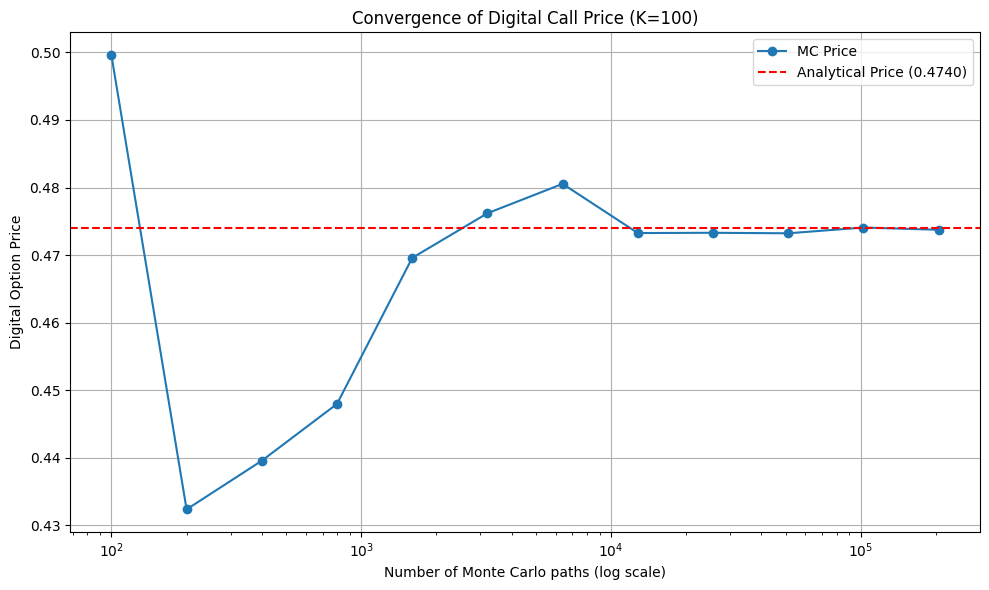

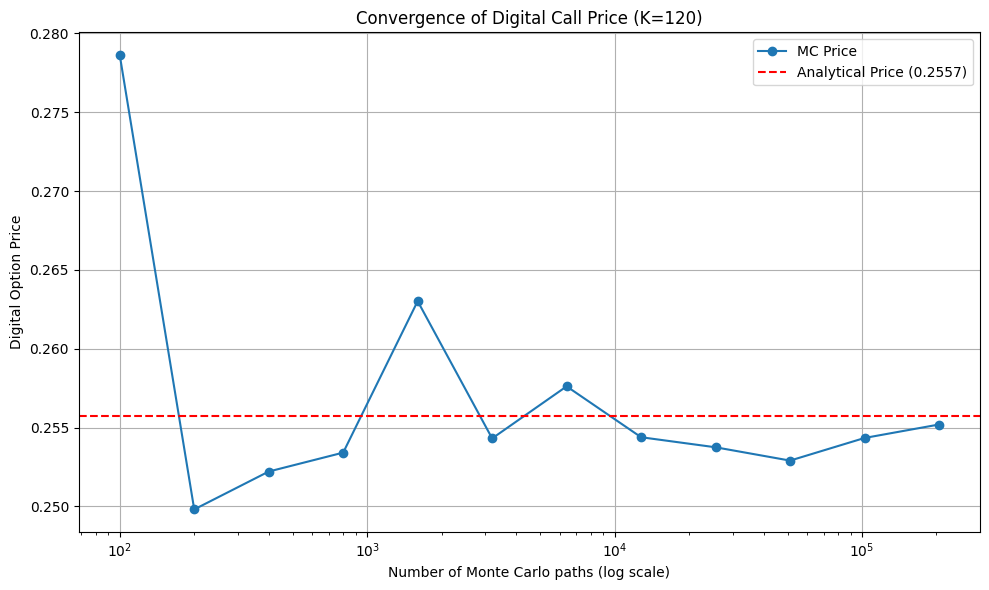

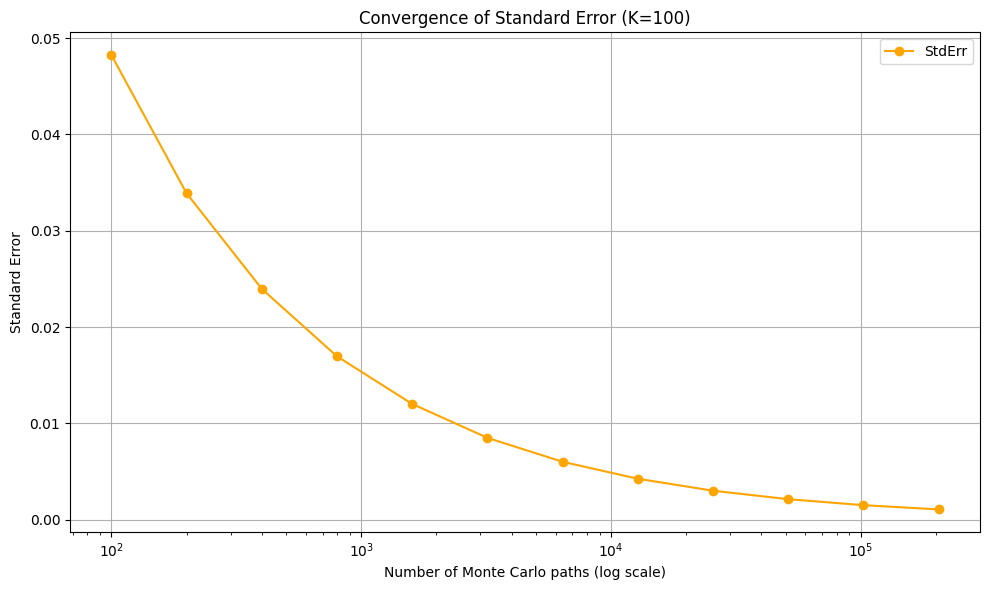

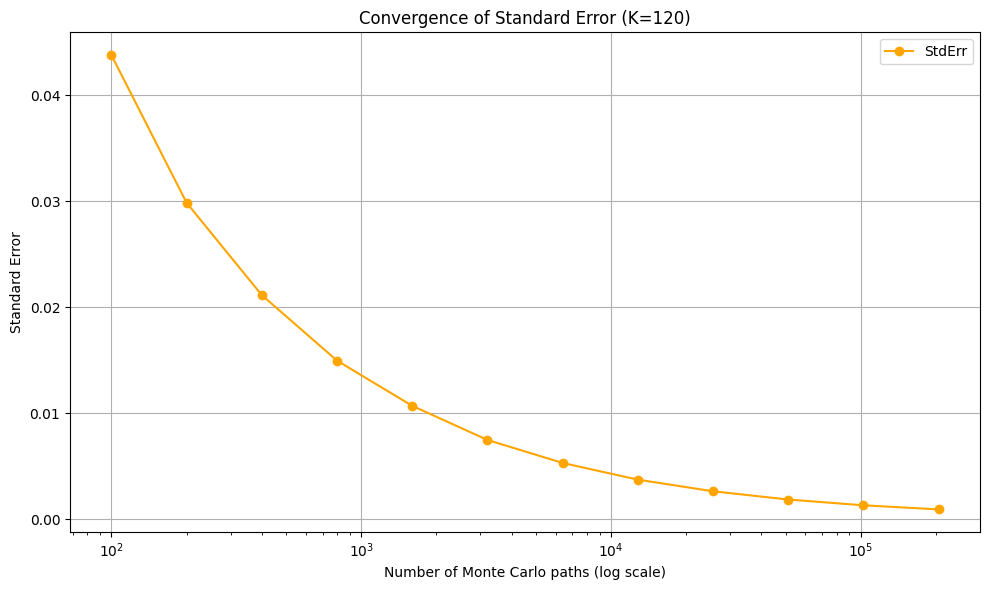

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Setup market
qf.mktClear()
qf.ycCreate("flat4", [1.0], [0.04], 1)

# Parameters
spot = 100
timetoexp = 1.0
divyield = 0.0
vol = 0.30
yc_name = "flat4"
payofftype = 1  # call
mcparams = {
    "URNGTYPE": "MT19937",
    "PATHGENTYPE": "EULER",
    "CONTROLVARTYPE": "NONE"
}
strikes = [100, 120]
npaths_list = [100 * 2**i for i in range(0, 12)]

# Store results
prices = {K: [] for K in strikes}
errors = {K: [] for K in strikes}
analytical = {}

# Loop over paths and strikes
for K in strikes:
    # get analytical price
    bs = qf.digiBS(payofftype, spot, K, timetoexp, 0.04, divyield, vol)[0]
    analytical[K] = bs

    for npaths in npaths_list:
        result = qf.digiBSMC(
            payofftype,
            K,
            timetoexp,
            spot,
            yc_name,
            divyield,
            vol,
            mcparams,
            npaths
        )
        prices[K].append(result["Mean"])
        errors[K].append(result["StdErr"])

# Plot price convergence for each strike
for K in strikes:
    plt.figure(figsize=(10, 6))
    plt.plot(npaths_list, prices[K], label="MC Price", marker='o')
    plt.axhline(y=analytical[K], color='red', linestyle='--', label=f"Analytical Price ({analytical[K]:.4f})")
    plt.xscale('log')
    plt.xlabel("Number of Monte Carlo paths (log scale)")
    plt.ylabel("Digital Option Price")
    plt.title(f"Convergence of Digital Call Price (K={K})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot standard error for each strike
for K in strikes:
    plt.figure(figsize=(10, 6))
    plt.plot(npaths_list, errors[K], label="StdErr", marker='o', color='orange')
    plt.xscale('log')
    plt.xlabel("Number of Monte Carlo paths (log scale)")
    plt.ylabel("Standard Error")
    plt.title(f"Convergence of Standard Error (K={K})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()